In [ ]:
!git clone https://github.com/gveres/donateacry-corpus.git

Cloning into 'donateacry-corpus'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616 (from 1)
Receiving objects: 100% (1616/1616), 67.06 MiB | 28.34 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [26]:
!pip install librosa xgboost gradio scikit-learn tensorflow matplotlib seaborn --quiet

In [ ]:
import os, librosa, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import joblib
import gradio as gr

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Database"

filepaths, labels = [], []
for label in os.listdir(DATA_PATH):
    label_path = os.path.join(DATA_PATH, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.endswith(".wav"):
                filepaths.append(os.path.join(label_path, file))
                labels.append(label)

meta = pd.DataFrame({"filepath": filepaths, "label": labels})
print("Total Samples:", len(meta))
print(meta["label"].value_counts())

Total Samples: 680
label
hungry        364
discomfort     99
belly_pain     91
tired          69
burping        57
Name: count, dtype: int64


In [21]:
# 2. Feature Extraction
# ----------------------------------------------------
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None, duration=5)
        features = {}

        # Basic features
        features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))
        features['rmse'] = np.mean(librosa.feature.rms(y=y))
        features['centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        features['bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        features['rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        features['chroma'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
        features['flatness'] = np.mean(librosa.feature.spectral_flatness(y=y))

        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)
        for i, val in enumerate(mfccs_mean):
            features[f'mfcc_{i}'] = val

        # Spectral contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=5, fmin=50.0)
        contrast_mean = np.mean(contrast, axis=1)
        for i, val in enumerate(contrast_mean):
            features[f'contrast_{i}'] = val

        return features
    except:
        return None

print("Extracting features...")
all_features = []
for index, row in tqdm(meta.iterrows(), total=meta.shape[0]):
    feats = extract_features(row['filepath'])
    if feats:
        feats['label'] = row['label']
        all_features.append(feats)

df_features = pd.DataFrame(all_features).dropna()
print("Final Feature Matrix Shape:", df_features.shape)

Extracting features...


100%|██████████| 680/680 [00:59<00:00, 11.38it/s]

Final Feature Matrix Shape: (680, 27)


In [22]:
# 3. Train-Test Split + Balancing

X = df_features.drop("label", axis=1).values
y = df_features["label"].values

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=1, stratify=y_enc
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE :", np.bincount(y_train_res))

# Compute class weights
classes = np.unique(y_train_res)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train_res)
class_weights_dict = {i: w for i, w in zip(classes, class_weights)}

Before SMOTE: [ 73  46  79 291  55]
After SMOTE : [291 291 291 291 291]


In [23]:
# ----------------------------------------------------
# 4. Train Models
# ----------------------------------------------------
ml_models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(random_state=1, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=1, class_weight="balanced"),
    "XGBoost": xgb.XGBClassifier(eval_metric="mlogloss", random_state=1)
}

results, conf_matrices = {}, {}

for name, model in ml_models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    results[name] = {"Accuracy": acc, "Macro F1": macro_f1, "Balanced Acc": bal_acc}
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    print(f"\n{name}")
    print(f" Accuracy: {acc:.4f}")
    print(f" Macro F1: {macro_f1:.4f}")
    print(f" Balanced Acc: {bal_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

df_results = pd.DataFrame(results).T
print("\nModel Comparison:\n", df_results)


KNN
 Accuracy: 0.7206
 Macro F1: 0.7363
 Balanced Acc: 0.8574
              precision    recall  f1-score   support

  belly_pain       0.60      1.00      0.75        18
     burping       0.71      0.91      0.80        11
  discomfort       0.59      1.00      0.74        20
      hungry       1.00      0.52      0.68        73
       tired       0.60      0.86      0.71        14

    accuracy                           0.72       136
   macro avg       0.70      0.86      0.74       136
weighted avg       0.82      0.72      0.71       136


SVM
 Accuracy: 0.8971
 Macro F1: 0.8958
 Balanced Acc: 0.9086
              precision    recall  f1-score   support

  belly_pain       0.90      1.00      0.95        18
     burping       1.00      0.91      0.95        11
  discomfort       0.86      0.90      0.88        20
      hungry       0.93      0.88      0.90        73
       tired       0.75      0.86      0.80        14

    accuracy                           0.90       136
   ma

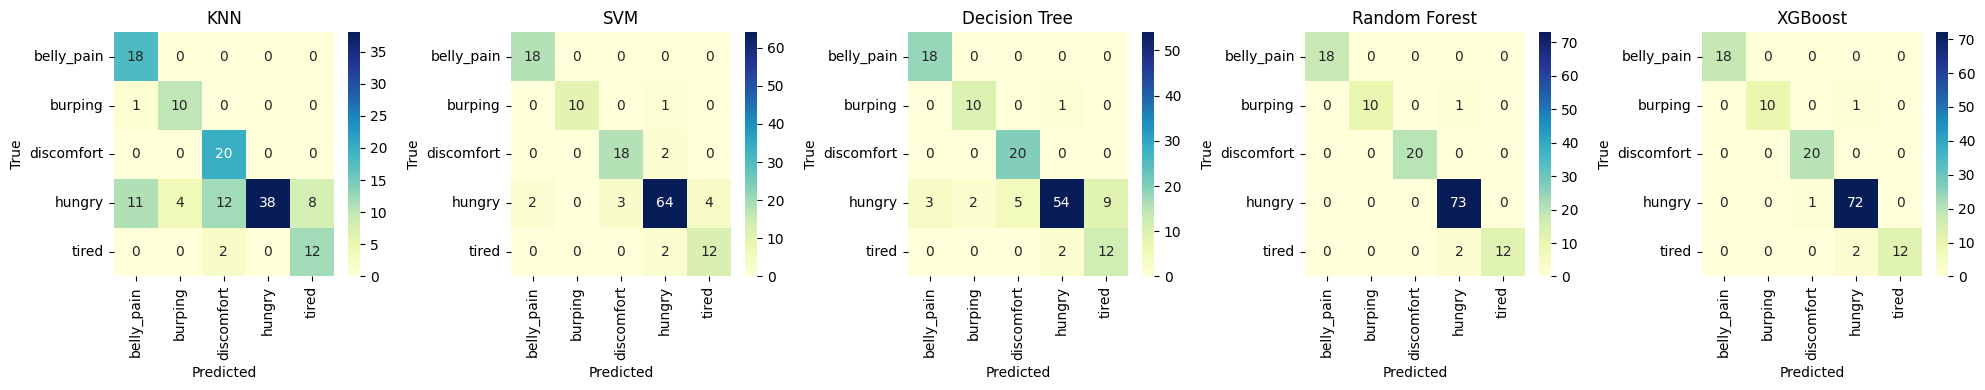

In [24]:
# Confusion Matrices Visualization
fig, axes = plt.subplots(1, len(conf_matrices), figsize=(20, 4))

if len(conf_matrices) == 1:
    axes = [axes]  # handle single model case

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

In [33]:
save_model = ml_models["Random Forest"]
joblib.dump(best_model, "save_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")
print("Model + Preprocessing saved!")

Model + Preprocessing saved!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,709 (12.61 MB)

 Trainable params: 3,304,709 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3313 - loss: 13.2404 - val_accuracy: 0.5368 - val_loss: 1.4295
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5428 - loss: 1.3629 - val_accuracy: 0.5368 - val_loss: 1.3050
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5708 - loss: 1.3115 - val_accuracy: 0.5368 - val_loss: 1.2690
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5210 - loss: 1.2800 - val_accuracy: 0.5368 - val_loss: 1.2338
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5824 - loss: 1.1102 - val_accuracy: 0.5441 - val_loss: 1.1500
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5812 - loss: 1.0035 - val_accuracy: 0.6250 - val_loss: 1.0241
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7067 - loss: 0.7933 - val_accuracy: 0.6618 - val_loss: 0.8721
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7799 - loss: 0.6229 - val_accuracy: 0.6544 - val_loss

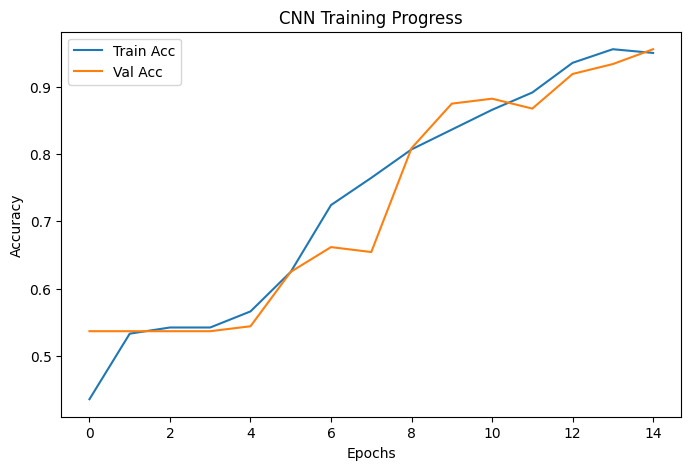

In [25]:
# Deep Learning 2D CNN on Mel-Spectrograms

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

def extract_mel(file_path, n_mels=128):
    y, sr = librosa.load(file_path, sr=None, duration=3.0)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Pad/crop to 128 frames
    if mel_db.shape[1] < 128:
        mel_db = np.pad(mel_db, ((0,0),(0,128-mel_db.shape[1])), mode="constant")
    else:
        mel_db = mel_db[:, :128]
    return mel_db

X_mel, y_mel = [], []
for fp, label in zip(meta["filepath"], meta["label"]):
    try:
        X_mel.append(extract_mel(fp))
        y_mel.append(label)
    except:
        pass

X_mel = np.array(X_mel)
y_mel = np.array(y_mel)

# Encode labels
y_mel_enc = le.fit_transform(y_mel)
y_mel_cat = to_categorical(y_mel_enc)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_mel, y_mel_cat, test_size=0.2, random_state=42, stratify=y_mel_cat
)

# Add channel dimension
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# CNN Model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation="softmax")
])

cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn_model.summary()

# Train
history = cnn_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss, acc = cnn_model.evaluate(X_test, y_test)
print(f"\nCNN Accuracy: {acc:.4f}")

# Plot training curve
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("CNN Training Progress")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step


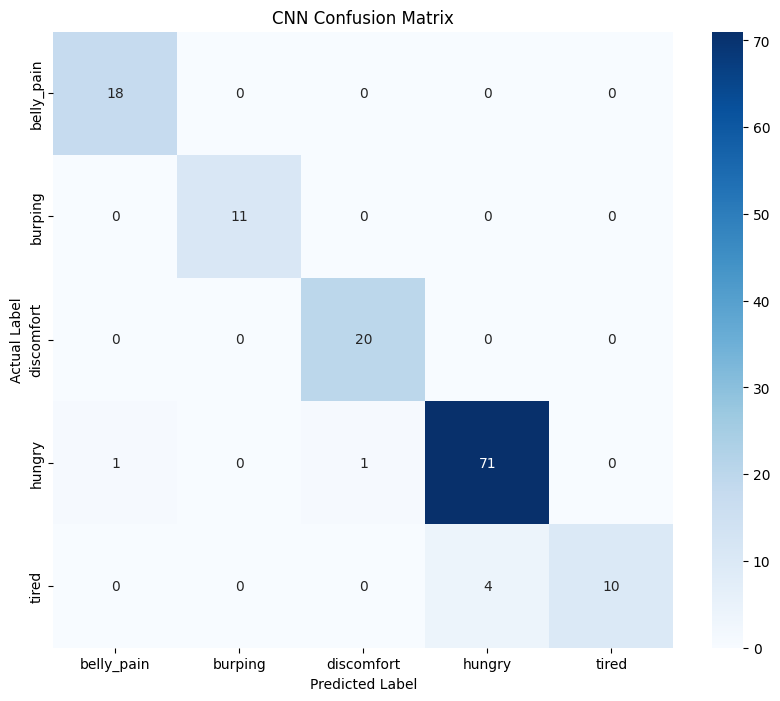

In [36]:
y_pred_probs = cnn_model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true_labels = np.argmax(y_test, axis=1)

class_names = le.classes_

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


In [34]:
# Gradio GUI

def extract_features_single(file_path):
    feats = extract_features(file_path)
    return np.array(list(feats.values())).reshape(1, -1)

def predict(audio_file):
    try:
        feats = extract_features_single(audio_file)
        feats_scaled = scaler.transform(feats)

        model = joblib.load("best_model.pkl")
        le = joblib.load("label_encoder.pkl")
        probs = model.predict_proba(feats_scaled)[0]
        pred = np.argmax(probs)

        label = le.inverse_transform([pred])[0]
        prob_dict = {le.classes_[i]: float(probs[i]) for i in range(len(probs))}
        return f"Predicted: {label}", prob_dict
    except Exception as e:
        return f"Error: {str(e)}", {}

with gr.Blocks() as demo:
    gr.Markdown("# 🐣 Infant Cry Classification")

    with gr.Tab("Predict"):
        audio_input = gr.Audio(type="filepath", label="Upload Cry Audio (.wav)")
        output_label = gr.Textbox(label="Prediction")
        output_probs = gr.Label(label="Class Probabilities")
        btn = gr.Button("Classify")
        btn.click(fn=predict, inputs=audio_input, outputs=[output_label, output_probs])

'''    with gr.Tab("Model Performance"):
        gr.Markdown("### Confusion Matrices for All Models")
        conf_img = gr.Image("confusion_matrices.png", type="filepath")'''


demo.launch(debug=True,share =False)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


In [ ]:
n